import necessary libs

In [ ]:
from pymatgen.core import Structure, Lattice
from pymatgen.entries.computed_entries import ComputedStructureEntry
import json 
import pandas as pd
from tqdm import tqdm
import os
from typing import Dict, Tuple
import shutil
import warnings

Next, I process each dataset from their source file into the type I require

## Alexandria

---

In [ ]:
def move_files(source_directory: str, destination_directory: str) -> None:
    """
    Moves all files from the source directory to the destination directory.
    If the destination directory does not exist, it will be created.

    :param source_directory: Path to the source directory containing the files to be moved.
    :param destination_directory: Path to the destination directory where files will be moved.
    """
    # Create the destination directory if it doesn't exist
    os.makedirs(destination_directory, exist_ok=True)

    # Walk through the source directory
    for root, dirs, files in os.walk(source_directory):
        for file in files:
            # Construct the full path of the source file
            source_file_path = os.path.join(root, file)
            # Construct the full path of the destination file
            destination_file_path = os.path.join(destination_directory, file)

            # Move the file from the source to the destination
            shutil.move(source_file_path, destination_file_path)
            print(f"Moved file: {source_file_path} -> {destination_file_path}")

source_directory = 'alexandria\\1'
destination_directory = 'alexandria\\'

move_files(source_directory, destination_directory)

In [ ]:
def open_json(path: str):
    with open(path) as file:
        data = json.load(file)
    return data['entries']

In [ ]:
def from_entry_to_cif_energy(data: Dict) -> Tuple[str, Dict]:
    """
    Converts a dictionary containing structure and energy data into a CIF string and energy-related data.

    :param data: A dictionary containing structure and energy information. Expected keys:
                 - 'structure': A dictionary with 'lattice' and 'sites' data.
                 - 'energy': The energy value of the structure.
                 - 'correction': Energy correction value.
                 - 'entry_id': Unique identifier for the entry.
                 - 'parameters': Additional parameters.
                 - 'composition': Composition of the structure.
                 - 'data': Additional data.
    :return: A tuple containing:
             - CIF string representation of the structure.
             - A dictionary with energy-related data.
    """
    # Extract lattice information and create a Lattice object
    lattice = Lattice(data['structure']['lattice']['matrix'])

    # Extract species and coordinates from the structure data
    species = []
    coords = []
    for site in data['structure']['sites']:
        for specie in site['species']:
            species.append(specie['element'])
            coords.append(site['xyz'])

    # Create a Structure object using the lattice, species, and coordinates
    structure = Structure(lattice, species, coords)

    # Create a ComputedStructureEntry object to store structure and energy data
    entry = ComputedStructureEntry(
        structure=structure,
        energy=data['energy'],
        correction=data['correction'],
        entry_id=data['entry_id'],
        parameters=data['parameters'],
        composition=data['composition'],
        data=data['data']
    )

    # Convert the structure to a CIF string
    cif_string = structure.to(fmt='cif')

    # Return the CIF string and the energy-related data
    return cif_string, entry.data

In [ ]:
def create_dataframe(files: list, path_to_callback: str):
    cifs_for_dataframe = []
    data_for_dataframe = []
    for file in tqdm(files):
        entrys = open_json(file)
        cifs_for_callback = []
        data_for_callback = []
        
        for entry in entrys:
            cif, entry_data = from_entry_to_cif_energy(entry)
            cifs_for_callback.append(cif)
            data_for_callback.append(entry_data)
        
        callback_df = pd.concat([pd.DataFrame(data_for_callback), pd.DataFrame({"cif": cifs_for_callback})], axis=1)
        callback_df.to_csv(path_to_callback + os.path.basename(file)[:-5] + ".csv")
        
        data_for_dataframe += data_for_callback
        cifs_for_dataframe += cifs_for_callback
            
    df_entry_data = pd.DataFrame(data_for_dataframe)
    df_cif = pd.DataFrame({"cif": cifs_for_dataframe})
    
    final_df = pd.concat([df_entry_data, df_cif], axis=1)
    
    return final_df            
        

In [ ]:
directory_path = 'alexandria\\jsons\\'

files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

In [ ]:
alexandria_dataframe = create_dataframe(["\\alexandria\convex_hull_pbe.json"], "alexandria\\callbacks\\")

In [ ]:
directory_path = 'alexandria\callbacks'
output_file_path = 'alexandria\\alexandria_full.csv'

csv_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]

dataframes = []

for csv_file in csv_files:
    file_path = os.path.join(directory_path, csv_file)  
    df = pd.read_csv(file_path)
    dataframes.append(df)  

combined_df = pd.concat(dataframes, ignore_index=True)

combined_df.to_csv(output_file_path, index=False)

print(f"Все файлы объединены в: {output_file_path}")

In [ ]:
data = pd.read_csv("alexandria\\alexandria_full.csv")

In [ ]:
len(data.formula.unique())

In [ ]:
alex_pbe = pd.read_csv("alexandria/convex_hull_pbe.csv")

In [ ]:
len(alex_pbe.formula.unique())

In [ ]:
alex_pbe.columns

## Jarvis

In [ ]:
from jarvis.db.figshare import data

dft_3d = data('dft_3d')

In [ ]:
df = pd.DataFrame(dft_3d)

In [ ]:
def create_structure_from_data(data):
    """
    Создает объект Structure из предоставленных данных.

    :param data: dict, содержащий данные для создания структуры
    :return: pymatgen Structure
    """
    lattice_mat = data['lattice_mat']
    coords = data['coords']
    elements = data['elements']

    lattice = Lattice(lattice_mat)

    structure = Structure(lattice=lattice, species=elements, coords=coords)

    return structure

In [ ]:
atoms = df['atoms']
cifs_for_dataset = []
for atom in tqdm(atoms):
    cifs_for_dataset.append(create_structure_from_data(atom).to_file(fmt='cif'))

In [ ]:
df_cif = pd.DataFrame({"cif": cifs_for_dataset})
final_df = pd.concat([df, df_cif], axis=1)
final_df.to_csv('Jarvis/jarvis.csv')

In [ ]:
jarvis = pd.read_csv("Jarvis\\jarvis.csv")

In [ ]:
jarvis

In [ ]:
jarvis.columns

## AFlow

In [ ]:
import json
from urllib.request import urlopen
from urllib.error import URLError, HTTPError

API = 'http://aflow.org/API/aflux/'
MATCHBOOK = 'species(Metals)'
DIRECTIVE = '$paging(1)'
REQUEST = API + '?' + MATCHBOOK + ',' + DIRECTIVE

try:
    with urlopen(REQUEST) as response:
        data = response.read().decode('utf-8')
        if data:
            response_json = json.loads(data)
            print(response_json)
        else:
            print("Пустой ответ от сервера")
except HTTPError as e:
    print(f"HTTP ошибка: {e.code} - {e.reason}")
except URLError as e:
    print(f"Ошибка URL: {e.reason}")
except json.JSONDecodeError as e:
    print(f"Ошибка декодирования JSON: {e}")

In [ ]:
response_json

## perov_5

In [ ]:
perov = pd.read_csv("perov_5\\perov_5_file.csv")
perov

## carbon_24

In [ ]:
carbon = pd.read_csv("carbon_24\\carbon_24_file.csv")
carbon

In [ ]:
print(carbon.iloc[0].cif)

## mp_20

In [ ]:
mp = pd.read_csv("mp_20\\mp20_file.csv")
mp

In [ ]:
len(set(mp.material_id) & set(jarvis.reference))

## mpts_52

In [ ]:
mpts = pd.read_csv("mpts_52\\mpts_52.csv")
mpts

In [ ]:
len(set(mp.material_id) | set(mpts.material_id) | set(jarvis.reference))

## Merger

let's merge all correct dataset in one big dataset with union pack of columns (material_id, cif, ref). List of datasets: alexandria_pbe, carbon_24, Jarvis, mp_20, mpts_52, perov_5

In [28]:
jarvis = pd.read_csv("../data/Jarvis/jarvis.csv")
mpts = pd.read_csv("../data/mpts_52/mpts_52.csv")
mp = pd.read_csv("../data/mp_20/mp_20.csv")
carbon = pd.read_csv("../data/carbon_24/carbon_24.csv")
alex_pbe = pd.read_csv("../data/alexandria/alexandria_pbe.csv")
perov = pd.read_csv("../data/perov_5/perov_5.csv")

C:\Users\user\AppData\Local\Temp\ipykernel_15744\267735639.py:1: DtypeWarning: Columns (14,17,26,30) have mixed types. Specify dtype option on import or set low_memory=False.
  jarvis = pd.read_csv("../data/Jarvis/jarvis.csv")


### jarvis -> jarvis_cry

In [29]:
jarvis_cry = jarvis[[ "reference", "cif"]]

In [30]:
jarvis_cry.columns = ["material_id", "cif"]

In [31]:
jarvis_cry['ref'] = 'jarvis'
jarvis_cry

C:\Users\user\AppData\Local\Temp\ipykernel_15744\940680558.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jarvis_cry['ref'] = 'jarvis'


,material_id,cif,ref
0,mp-1080455,# generated using pymatgen\ndata_TiCuSiAs\n_sy...,jarvis
1,mp-568319,# generated using pymatgen\ndata_DyB6\n_symmet...,jarvis
2,auid-3eaf68dd483bf4f4,# generated using pymatgen\ndata_Be2OsRu\n_sym...,jarvis
3,mp-31104,# generated using pymatgen\ndata_KBi\n_symmetr...,jarvis
4,mp-694,# generated using pymatgen\ndata_VSe2\n_symmet...,jarvis
...,...,...,...
75988,1206834,# generated using pymatgen\ndata_Ac(RhPb)2\n_s...,jarvis
75989,915022,# generated using pymatgen\ndata_PrTlZn\n_symm...,jarvis
75990,1214095,# generated using pymatgen\ndata_Ba(InBi)2\n_s...,jarvis
75991,1206745,# generated using pymatgen\ndata_Tm(SiTc)2\n_s...,jarvis


In Jarvis 3 type of datasets with different prefixes

- Material Project with prefix 'mp-'
- Aflow with prefix 'auid'
- Uniq Jarvis without prefix

### mpts_52 -> mpts_cry

In [32]:
mpts_cry = mpts[["material_id", "cif"]]

In [33]:
mpts_cry['ref'] = 'mpts_52'
mpts_cry

C:\Users\user\AppData\Local\Temp\ipykernel_15744\4020229141.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mpts_cry['ref'] = 'mpts_52'


,material_id,cif,ref
0,mp-66,# generated using pymatgen\ndata_C\n_symmetry_...,mpts_52
1,mp-22862,# generated using pymatgen\ndata_NaCl\n_symmet...,mpts_52
2,mp-30,# generated using pymatgen\ndata_Cu\n_symmetry...,mpts_52
3,mp-2741,# generated using pymatgen\ndata_CaF2\n_symmet...,mpts_52
4,mp-1455,# generated using pymatgen\ndata_MnS2\n_symmet...,mpts_52
...,...,...,...
40471,mp-11924,# generated using pymatgen\ndata_Rb2TaCuSe4\n_...,mpts_52
40472,mp-11775,# generated using pymatgen\ndata_RbUO3\n_symme...,mpts_52
40473,mp-31118,# generated using pymatgen\ndata_SmScO3\n_symm...,mpts_52
40474,mp-11778,# generated using pymatgen\ndata_ThMnSe3\n_sym...,mpts_52


### mp_20 -> mp_cry

In [35]:
mp_cry = mp[['material_id', "cif"]]
mp_cry['ref'] = 'mp_20'
mp_cry

C:\Users\user\AppData\Local\Temp\ipykernel_15744\3588085306.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mp_cry['ref'] = 'mp_20'


,material_id,cif,ref
0,mp-1221227,# generated using pymatgen\ndata_Na3MnCoNiO6\n...,mp_20
1,mp-974729,# generated using pymatgen\ndata_Nd(Al2Cu)4\n_...,mp_20
2,mp-1185360,# generated using pymatgen\ndata_LiMnIr2\n_sym...,mp_20
3,mp-1188861,# generated using pymatgen\ndata_LiCSN\n_symme...,mp_20
4,mp-677272,# generated using pymatgen\ndata_La2EuS4\n_sym...,mp_20
...,...,...,...
45224,mp-1023925,# generated using pymatgen\ndata_WS2\n_symmetr...,mp_20
45225,mp-1187764,# generated using pymatgen\ndata_Y2ZnPt\n_symm...,mp_20
45226,mp-1219588,# generated using pymatgen\ndata_RbMgCoF6\n_sy...,mp_20
45227,mp-3589,# generated using pymatgen\ndata_BPO4\n_symmet...,mp_20


### carbon_24 -> carbon_cry

In [36]:
carbon_cry = carbon.drop(["energy_per_atom", 'Unnamed: 0'], axis=1)

In [37]:
carbon_cry['ref'] = 'carbon_24'
carbon_cry

,material_id,cif,ref
0,C-130499-1826-36,# generated using pymatgen\ndata_C\n_symmetry_...,carbon_24
1,C-13904-4247-31,# generated using pymatgen\ndata_C\n_symmetry_...,carbon_24
2,C-92138-4782-35,# generated using pymatgen\ndata_C\n_symmetry_...,carbon_24
3,C-192672-505-73,# generated using pymatgen\ndata_C\n_symmetry_...,carbon_24
4,C-193956-5355-22,# generated using pymatgen\ndata_C\n_symmetry_...,carbon_24
...,...,...,...
10148,C-193926-6320-8,# generated using pymatgen\ndata_C\n_symmetry_...,carbon_24
10149,C-13665-1988-16,# generated using pymatgen\ndata_C\n_symmetry_...,carbon_24
10150,C-142855-9438-3,# generated using pymatgen\ndata_C\n_symmetry_...,carbon_24
10151,C-13640-2755-30,# generated using pymatgen\ndata_C\n_symmetry_...,carbon_24


### alexandria_pbe -> alex_pbe_cry

In [38]:
alex_pbe_cry = alex_pbe[["mat_id", "cif"]]

In [39]:
alex_pbe_cry.columns = ["material_id", "cif"]

In [40]:
alex_pbe_cry['ref'] = 'alex_pbe'
alex_pbe_cry

C:\Users\user\AppData\Local\Temp\ipykernel_15744\496001735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alex_pbe_cry['ref'] = 'alex_pbe'


,material_id,cif,ref
0,agm048224876,# generated using pymatgen\ndata_Al4IrRu3\n_sy...,alex_pbe
1,agm002302240,# generated using pymatgen\ndata_EuAgTeO\n_sym...,alex_pbe
2,agm003161479,# generated using pymatgen\ndata_CaTlAg\n_symm...,alex_pbe
3,agm003330027,# generated using pymatgen\ndata_Tm3Ge3Ir2\n_s...,alex_pbe
4,agm002198109,# generated using pymatgen\ndata_EuAl4Pd\n_sym...,alex_pbe
...,...,...,...
144646,agm005618834,# generated using pymatgen\ndata_Sm3Ga2Ir7\n_s...,alex_pbe
144647,agm003208591,# generated using pymatgen\ndata_Li(Fe3Ge2)2\n...,alex_pbe
144648,agm005866520,# generated using pymatgen\ndata_Nb12Sn3W\n_sy...,alex_pbe
144649,agm003157526,# generated using pymatgen\ndata_CeP\n_symmetr...,alex_pbe


### perov_5 -> perov_cry

In [41]:
perov_cry = perov[["material_id", "cif"]]

for understand diff between Jarvis and perov_5 datasets let's add prefix 'p-' for perov srtuctures

In [42]:
perov_cry['material_id'] = 'p-' + perov_cry['material_id'].astype(str)

C:\Users\user\AppData\Local\Temp\ipykernel_15744\2236623699.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perov_cry['material_id'] = 'p-' + perov_cry['material_id'].astype(str)


In [43]:
perov_cry['ref'] = 'perov_5'
perov_cry

C:\Users\user\AppData\Local\Temp\ipykernel_15744\1754439102.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perov_cry['ref'] = 'perov_5'


,material_id,cif,ref
0,p-6334,# generated using pymatgen\ndata_TlCoN2O\n_sym...,perov_5
1,p-17313,# generated using pymatgen\ndata_CrTeN3\n_symm...,perov_5
2,p-6840,# generated using pymatgen\ndata_SbTeN2O\n_sym...,perov_5
3,p-11379,# generated using pymatgen\ndata_NiPtO2F\n_sym...,perov_5
4,p-16590,# generated using pymatgen\ndata_YGeN3\n_symme...,perov_5
...,...,...,...
18923,p-6452,# generated using pymatgen\ndata_CsNbN2O\n_sym...,perov_5
18924,p-7673,# generated using pymatgen\ndata_FePbN2O\n_sym...,perov_5
18925,p-819,# generated using pymatgen\ndata_NaGeNO2\n_sym...,perov_5
18926,p-11261,# generated using pymatgen\ndata_TeAuO2F\n_sym...,perov_5


### concat

In [44]:
genCry = pd.concat([mp_cry, mpts_cry, jarvis_cry, alex_pbe_cry, carbon_cry, perov_cry], ignore_index=True)

Jarvis, mp_20 and mpts_52 have crystalls from material project, so necessary to drop duplicates of this structures

In [45]:
genCry = genCry.drop_duplicates(subset=['material_id', 'cif'])

In [46]:
genCry = genCry.reset_index().drop("index", axis=1)
genCry

,material_id,cif,ref
0,mp-1221227,# generated using pymatgen\ndata_Na3MnCoNiO6\n...,mp_20
1,mp-974729,# generated using pymatgen\ndata_Nd(Al2Cu)4\n_...,mp_20
2,mp-1185360,# generated using pymatgen\ndata_LiMnIr2\n_sym...,mp_20
3,mp-1188861,# generated using pymatgen\ndata_LiCSN\n_symme...,mp_20
4,mp-677272,# generated using pymatgen\ndata_La2EuS4\n_sym...,mp_20
...,...,...,...
315444,p-6452,# generated using pymatgen\ndata_CsNbN2O\n_sym...,perov_5
315445,p-7673,# generated using pymatgen\ndata_FePbN2O\n_sym...,perov_5
315446,p-819,# generated using pymatgen\ndata_NaGeNO2\n_sym...,perov_5
315447,p-11261,# generated using pymatgen\ndata_TeAuO2F\n_sym...,perov_5


In [47]:
genCry.to_csv("../data/genCry.csv")

## Val

In [48]:
genCry = pd.read_csv("../data/genCry.csv")

mpts_cry have some structures with 1-2 atoms and we need to drop it & some cifs can be broken

In [56]:
from pymatgen.core.structure import Structure
from pymatgen.io.cif import CifParser
from io import StringIO
from typing import List, Optional

def filter_structures_from_dataframe(
    dataframe: pd.DataFrame,
    cif_column: str = "cif",
    material_id_column: str = "material_id",
    ref_column: str = "ref",
    num_of_atoms: int = 2,
    output_file: Optional[str] = None
) -> pd.DataFrame:
    """
    Filters structures from a DataFrame containing CIF strings based on the number of atoms.
    Returns a new DataFrame with only the structures that have more than the specified number of atoms.

    :param dataframe: Input DataFrame containing CIF strings and material IDs.
    :param cif_column: Name of the column in the DataFrame that contains the CIF strings. Default is "cif".
    :param material_id_column: Name of the column in the DataFrame that contains the material IDs. Default is "material_id".
    :param num_of_atoms: Minimum number of atoms a structure must have to be included in the result. Default is 2.
    :param ref_column: Name of the column in the DataFrame that contains reference data. Default is "ref".
    :param output_file: Path to the file where the filtered DataFrame will be saved. If None, the file is not saved.
    :return: A DataFrame containing the filtered structures with their material IDs and CIF strings.
    """
    warnings.filterwarnings("ignore", category=UserWarning)
    
    filtered_data = []

    for index, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        mat_id = row[material_id_column]
        cif_string = row[cif_column]
        ref = row[ref_column]

        try:
            # Convert the CIF string into a file-like object for parsing
            cif_file_like = StringIO(cif_string)

            # Parse the CIF string into a pymatgen Structure object
            parser = CifParser(cif_file_like)
            structure = parser.get_structures()[0]

            # Check if the structure has more than the specified number of atoms
            if len(structure) > num_of_atoms:
                filtered_data.append({
                    material_id_column: mat_id,
                    cif_column: cif_string,
                    ref_column: ref
                })
        except Exception as e:
            print(f"Error processing row {index}: {e}")

    filtered_df = pd.DataFrame(filtered_data).reset_index().drop("index", axis=1)
    
    if output_file:
        filtered_df.to_csv(output_file, index=False)
        print(f"Filtered data saved to file: {output_file}")
    
    return filtered_df

In [57]:
genCry_filtered = filter_structures_from_dataframe(genCry, output_file="../data/genCry_f.csv")

  0%|          | 0/315449 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_15744\2600575588.py:41: FutureWarning: get_structures is deprecated; use parse_structures in pymatgen.io.cif instead.
The only difference is that primitive defaults to False in the new parse_structures method.So parse_structures(primitive=True) is equivalent to the old behavior of get_structures().
  structure = parser.get_structures()[0]
 24%|██▎       | 74315/315449 [04:56<09:28, 424.36it/s]

Error processing row 74238: Invalid CIF file with no structures!


 31%|███▏      | 98861/315449 [06:03<09:46, 369.02it/s]

Error processing row 98821: Invalid CIF file with no structures!


 32%|███▏      | 102217/315449 [06:11<08:12, 433.13it/s]

Error processing row 102157: Invalid CIF file with no structures!


 33%|███▎      | 104257/315449 [06:17<12:09, 289.44it/s]

Error processing row 104211: Invalid CIF file with no structures!


 34%|███▍      | 107022/315449 [06:27<10:30, 330.67it/s]

Error processing row 106965: Invalid CIF file with no structures!


 34%|███▍      | 107195/315449 [06:27<10:22, 334.66it/s]

Error processing row 107160: Invalid CIF file with no structures!


 35%|███▍      | 108931/315449 [06:33<10:55, 314.87it/s]

Error processing row 108875: Invalid CIF file with no structures!


 39%|███▉      | 122516/315449 [07:14<06:52, 468.21it/s]

Error processing row 122458: Invalid CIF file with no structures!


 39%|███▉      | 123161/315449 [07:15<06:58, 459.44it/s]

Error processing row 123100: Invalid CIF file with no structures!


 40%|████      | 127475/315449 [07:27<09:17, 337.23it/s]

Error processing row 127427: Invalid CIF file with no structures!


 44%|████▎     | 137275/315449 [07:58<09:44, 304.64it/s]

Error processing row 137235: Invalid CIF file with no structures!


 44%|████▍     | 138468/315449 [08:01<09:38, 305.97it/s]

Error processing row 138405: Invalid CIF file with no structures!


 44%|████▍     | 138687/315449 [08:02<09:41, 303.77it/s]

Error processing row 138634: Invalid CIF file with no structures!


 46%|████▌     | 144844/315449 [08:26<11:14, 253.08it/s]

Error processing row 144825: Invalid CIF file with no structures!


 46%|████▋     | 146576/315449 [08:33<11:12, 251.22it/s]

Error processing row 146554: Invalid CIF file with no structures!


 47%|████▋     | 146902/315449 [08:34<11:14, 249.86it/s]

Error processing row 146858: Invalid CIF file with no structures!


 47%|████▋     | 147282/315449 [08:35<11:24, 245.75it/s]

Error processing row 147244: Invalid CIF file with no structures!


 48%|████▊     | 149938/315449 [08:48<22:07, 124.71it/s]

Error processing row 149923: Invalid CIF file with no structures!


 48%|████▊     | 151163/315449 [08:53<10:14, 267.29it/s]

Error processing row 151140: Invalid CIF file with no structures!


 49%|████▊     | 153504/315449 [09:03<13:02, 207.00it/s]

Error processing row 153482: Invalid CIF file with no structures!


 49%|████▉     | 155461/315449 [09:11<09:31, 279.78it/s]

Error processing row 155407: Invalid CIF file with no structures!


 50%|█████     | 158497/315449 [09:26<10:28, 249.61it/s]

Error processing row 158472: Invalid CIF file with no structures!


 51%|█████     | 159988/315449 [09:33<10:37, 243.97it/s]

Error processing row 159948: Invalid CIF file with no structures!


 51%|█████     | 160992/315449 [09:38<10:25, 246.75it/s]

Error processing row 160956: Invalid CIF file with no structures!


 52%|█████▏    | 163586/315449 [09:51<13:09, 192.35it/s]

Error processing row 163546: Invalid CIF file with no structures!


 53%|█████▎    | 166488/315449 [10:03<10:13, 242.99it/s]

Error processing row 166442: Invalid CIF file with no structures!


 53%|█████▎    | 167059/315449 [10:05<08:27, 292.55it/s]

Error processing row 167000: Invalid CIF file with no structures!


 53%|█████▎    | 167347/315449 [10:06<08:29, 290.48it/s]

Error processing row 167294: Invalid CIF file with no structures!


 53%|█████▎    | 167953/315449 [10:08<08:42, 282.23it/s]

Error processing row 167910: Invalid CIF file with no structures!


 54%|█████▍    | 170080/315449 [10:16<07:50, 309.17it/s]

Error processing row 170026: Invalid CIF file with no structures!


 55%|█████▌    | 175009/315449 [10:38<12:20, 189.65it/s]

Error processing row 174977: Invalid CIF file with no structures!


 56%|█████▌    | 176447/315449 [10:46<10:51, 213.44it/s]

Error processing row 176420: Invalid CIF file with no structures!


 58%|█████▊    | 182187/315449 [11:13<10:30, 211.50it/s]

Error processing row 182150: Invalid CIF file with no structures!


 58%|█████▊    | 183552/315449 [11:18<07:17, 301.16it/s]

Error processing row 183491: Invalid CIF file with no structures!


 59%|█████▉    | 185628/315449 [11:26<07:05, 304.85it/s]

Error processing row 185584: Invalid CIF file with no structures!


 60%|█████▉    | 188653/315449 [11:35<07:46, 271.59it/s]

Error processing row 188609: Invalid CIF file with no structures!


 61%|██████    | 192696/315449 [11:53<12:19, 165.95it/s]

Error processing row 192684: Invalid CIF file with no structures!


 61%|██████    | 192915/315449 [11:55<18:08, 112.52it/s]

Error processing row 192902: Invalid CIF file with no structures!


 61%|██████▏   | 193325/315449 [11:57<08:57, 227.29it/s]

Error processing row 193308: Invalid CIF file with no structures!


 62%|██████▏   | 195164/315449 [12:06<08:04, 248.05it/s]

Error processing row 195139: Invalid CIF file with no structures!


 62%|██████▏   | 196357/315449 [12:10<08:31, 233.01it/s]

Error processing row 196340: Invalid CIF file with no structures!


 63%|██████▎   | 199056/315449 [12:21<08:34, 226.43it/s]

Error processing row 199031: Invalid CIF file with no structures!


 63%|██████▎   | 199297/315449 [12:22<08:31, 226.93it/s]

Error processing row 199248: Invalid CIF file with no structures!


 64%|██████▍   | 202017/315449 [12:36<08:36, 219.44it/s]

Error processing row 201984: Invalid CIF file with no structures!


 65%|██████▍   | 204897/315449 [12:49<08:09, 225.84it/s]

Error processing row 204858: Invalid CIF file with no structures!


 65%|██████▌   | 206532/315449 [12:56<07:07, 254.75it/s]

Error processing row 206495: Invalid CIF file with no structures!


 66%|██████▌   | 206686/315449 [12:57<10:04, 179.85it/s]

Error processing row 206680: Invalid CIF file with no structures!


 67%|██████▋   | 211558/315449 [13:19<06:30, 266.24it/s]

Error processing row 211519: Invalid CIF file with no structures!


 69%|██████▊   | 216752/315449 [13:40<07:20, 224.20it/s]

Error processing row 216720: Invalid CIF file with no structures!


 69%|██████▉   | 217981/315449 [13:45<07:16, 223.23it/s]

Error processing row 217940: Invalid CIF file with no structures!
Error processing row 217955: Invalid CIF file with no structures!


 70%|██████▉   | 219268/315449 [13:51<09:02, 177.42it/s]

Error processing row 219240: Invalid CIF file with no structures!


 70%|██████▉   | 220669/315449 [13:57<07:34, 208.32it/s]

Error processing row 220649: Invalid CIF file with no structures!


 70%|███████   | 220868/315449 [13:58<06:37, 237.79it/s]

Error processing row 220823: Invalid CIF file with no structures!


 71%|███████   | 224712/315449 [14:16<06:39, 227.04it/s]

Error processing row 224668: Invalid CIF file with no structures!


 71%|███████▏  | 225045/315449 [14:17<07:52, 191.23it/s]

Error processing row 225024: Invalid CIF file with no structures!


 72%|███████▏  | 225749/315449 [14:20<05:47, 257.77it/s]

Error processing row 225693: Invalid CIF file with no structures!


 72%|███████▏  | 227723/315449 [14:31<06:01, 242.92it/s]

Error processing row 227685: Invalid CIF file with no structures!


 72%|███████▏  | 228690/315449 [14:34<05:02, 286.66it/s]

Error processing row 228652: Invalid CIF file with no structures!


 73%|███████▎  | 231313/315449 [14:46<06:44, 207.81it/s]

Error processing row 231291: Invalid CIF file with no structures!


 74%|███████▍  | 234403/315449 [14:57<04:31, 298.88it/s]

Error processing row 234348: Invalid CIF file with no structures!


 75%|███████▍  | 235036/315449 [15:00<05:06, 261.96it/s]

Error processing row 235002: Invalid CIF file with no structures!


 77%|███████▋  | 242503/315449 [15:28<05:12, 233.41it/s]

Error processing row 242455: Invalid CIF file with no structures!


 77%|███████▋  | 243874/315449 [15:33<03:59, 299.06it/s]

Error processing row 243814: Invalid CIF file with no structures!


 78%|███████▊  | 244794/315449 [15:37<04:03, 290.20it/s]

Error processing row 244761: Invalid CIF file with no structures!


 80%|███████▉  | 251994/315449 [16:04<03:50, 275.64it/s]

Error processing row 251971: Invalid CIF file with no structures!


 80%|████████  | 252943/315449 [16:08<04:09, 250.82it/s]

Error processing row 252916: Invalid CIF file with no structures!


 81%|████████  | 254511/315449 [16:15<03:59, 254.88it/s]

Error processing row 254472: Invalid CIF file with no structures!


 81%|████████  | 255652/315449 [16:20<04:13, 236.04it/s]

Error processing row 255619: Invalid CIF file with no structures!


 82%|████████▏ | 259786/315449 [16:38<03:55, 236.07it/s]

Error processing row 259756: Invalid CIF file with no structures!


 82%|████████▏ | 260235/315449 [16:42<05:55, 155.37it/s]

Error processing row 260210: Invalid CIF file with no structures!


 83%|████████▎ | 261269/315449 [16:48<04:01, 224.71it/s]

Error processing row 261260: Invalid CIF file with no structures!


 83%|████████▎ | 262303/315449 [16:55<06:49, 129.80it/s]

Error processing row 262279: Invalid CIF file with no structures!


 84%|████████▎ | 264145/315449 [17:07<05:34, 153.35it/s]

Error processing row 264123: Invalid CIF file with no structures!


 84%|████████▍ | 264437/315449 [17:08<05:25, 156.78it/s]

Error processing row 264410: Invalid CIF file with no structures!


 84%|████████▍ | 266455/315449 [17:18<02:57, 275.51it/s]

Error processing row 266397: Invalid CIF file with no structures!


 85%|████████▍ | 266846/315449 [17:20<02:58, 271.81it/s]

Error processing row 266799: Invalid CIF file with no structures!


 85%|████████▌ | 268589/315449 [17:27<02:52, 271.89it/s]

Error processing row 268534: Invalid CIF file with no structures!


 85%|████████▌ | 269081/315449 [17:28<02:28, 312.43it/s]

Error processing row 269038: Invalid CIF file with no structures!


 86%|████████▌ | 270815/315449 [17:35<03:13, 231.01it/s]

Error processing row 270779: Invalid CIF file with no structures!


 86%|████████▌ | 271884/315449 [17:40<02:35, 280.94it/s]

Error processing row 271817: Invalid CIF file with no structures!


 87%|████████▋ | 274733/315449 [17:53<02:36, 259.75it/s]

Error processing row 274687: Invalid CIF file with no structures!


 87%|████████▋ | 275962/315449 [17:58<02:45, 238.43it/s]

Error processing row 275946: Invalid CIF file with no structures!


 88%|████████▊ | 276515/315449 [18:00<02:44, 237.11it/s]

Error processing row 276490: Invalid CIF file with no structures!


 88%|████████▊ | 277107/315449 [18:03<02:44, 233.08it/s]

Error processing row 277059: Invalid CIF file with no structures!


 88%|████████▊ | 279051/315449 [18:11<02:22, 255.28it/s]

Error processing row 279024: Invalid CIF file with no structures!


 90%|████████▉ | 282836/315449 [18:27<02:06, 257.80it/s]

Error processing row 282787: Invalid CIF file with no structures!


100%|██████████| 315449/315449 [20:00<00:00, 262.77it/s]


Filtered data saved to file: ../data/genCry_f.csv


In [58]:
genCry_filtered

,material_id,cif,ref
0,mp-1221227,# generated using pymatgen\ndata_Na3MnCoNiO6\n...,mp_20
1,mp-974729,# generated using pymatgen\ndata_Nd(Al2Cu)4\n_...,mp_20
2,mp-1185360,# generated using pymatgen\ndata_LiMnIr2\n_sym...,mp_20
3,mp-1188861,# generated using pymatgen\ndata_LiCSN\n_symme...,mp_20
4,mp-677272,# generated using pymatgen\ndata_La2EuS4\n_sym...,mp_20
...,...,...,...
308226,p-6452,# generated using pymatgen\ndata_CsNbN2O\n_sym...,perov_5
308227,p-7673,# generated using pymatgen\ndata_FePbN2O\n_sym...,perov_5
308228,p-819,# generated using pymatgen\ndata_NaGeNO2\n_sym...,perov_5
308229,p-11261,# generated using pymatgen\ndata_TeAuO2F\n_sym...,perov_5


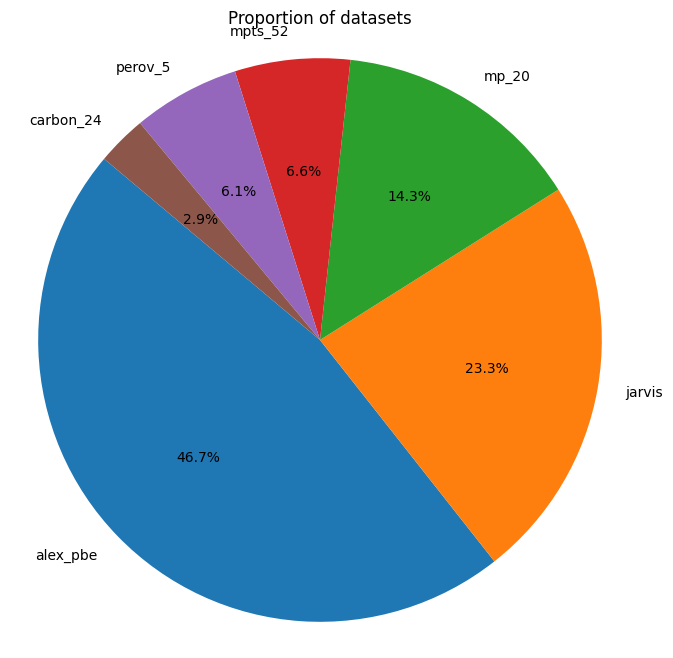

In [ ]:
import matplotlib.pyplot as plt
ref_counts = genCry_filtered['ref'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(ref_counts, labels=ref_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of datasets')
plt.axis('equal') 
plt.show()

In [ ]:
genCry_filtered['prefix'] = genCry_filtered['material_id'].str[:2]

unique_prefixes = genCry_filtered[genCry_filtered['ref']=='mpts_52']['prefix'].unique()
unique_prefixes

array(['mp'], dtype=object)